In [1]:
import jax
import jax.numpy as jnp
from jax import random
from jax import grad, jacobian, jit


from jax.experimental import optimizers as jax_opt
import numpy as np





In [2]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt

# SHAPER
from pyshaper.CommonObservables import buildCommmonObservables
from pyshaper.Observables import Observable
from pyshaper.Shaper import Shaper

# Utils
from utils import load_cmsopendata
from pyshaper.utils.plot_utils import plot_event


# Necessary GPU nonsense
import torch 

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 

Using CPU!


In [3]:
# Build 3 particle events
R = 1.0
N = 180
pad = 3
angles = np.linspace(0, np.pi, N)

events = []
for i in range(N):

    points = np.array([
                        (4/6, 0.0, 0.0),
                        (1/6, R, 0.0),
                        (1/6, R*np.cos(angles[i]), R*np.sin(angles[i]))
              ])
    events.append(points)
dataset = np.array(events)
print(dataset.shape)

(180, 3, 3)


In [4]:
# TODO: my SHAPER representation of events is somewhat inefficient. do over.
def compute_spectral_representation(events, pad = 125, omega_max = 2, type = "event", dtype = np.float32):

    # events shape is (batch_size, pad, 3)
    points, zs = events[:,:,1:], events[:,:,0]
    batch_size = zs.shape[0]
    euclidean_distance_squared = np.sum(np.square(points[:,:, None, :] - points[:,None, :, :]), axis=-1)
    

    # Upper Triangle Matrices
    if type == "event":
        omega_ij = np.triu(euclidean_distance_squared / 2)
    elif type == "jet":
        omega_ij = np.triu(np.sqrt(euclidean_distance_squared ))
    triangle_indices = np.triu_indices(pad, k = 1)

    ee_ij = np.triu(zs[:,:,None] * zs[:,None,:])
    ee2 = np.trace(ee_ij, axis1 = 1, axis2=2)

    # Flatten to 1D Spectral Representation and remove 0s
    omega_n = omega_ij[:,triangle_indices[0], triangle_indices[1]]
    ee_n = 2 * ee_ij[:,triangle_indices[0], triangle_indices[1]]
    mask = omega_n > 0


    s = np.stack((omega_n, ee_n), axis = 1)
    s = np.transpose(s, (0,2,1))
    print(s.shape)

    
    # Sort and append 0
    indices = s[:,:,0].argsort()
    temp_indices = np.arange(batch_size)[:,np.newaxis]
    s = s[temp_indices,indices]
    s0 = np.zeros((batch_size, 1, 2))
    s0[:,0,1] = ee2
    s = np.concatenate((s0, s), axis = 1)

    return s.astype(dtype)


s = compute_spectral_representation(dataset, pad = pad, type = "jet")

(180, 3, 2)


In [5]:
def weighted_sum(s, p = 2, max_index = None, inclusive = True):
    
    if max_index is None:
        return jnp.sum(s[:,:,1] * jnp.power(s[:,:,0], p), axis = -1)
    else:
        max_index = max_index + 1 if inclusive else max_index
        return jnp.sum(s[:,:max_index,1] * jnp.power(s[:,:max_index,0], p),axis = -1)


# def energy_sum(s, max_index = None, inclusive = True):
#     if max_index is None:def weighted_sum(s, p = 2, max_index = None, inclusive = True):
    
    if max_index is None:
        return jnp.sum(s[:,:,1] * jnp.power(s[:,:,0], p), axis = -1)
    else:
        max_index = max_index + 1 if inclusive else max_index
        return jnp.sum(s[:,:max_index,1] * jnp.power(s[:,:max_index,0], p),axis = -1)


# def energy_sum(s, max_index = None, inclusive = True):
#     if max_index is None:
#         return jnp.sum(s[:,1])
#     else:
#         max_index = max_index + 1 if inclusive else max_index
#         return jnp.sum(s[:max_index,1] )


def cross_term(s1, s2, pairwise = True):

    # Ijnput Parsing
    if pairwise == False:
        raise NotImplementedError("Pairwise sEMDs not implemented!")
    batch_size_1 = s1.shape[0]
    batch_size_2 = s2.shape[0]
    if batch_size_2 != batch_size_1 and pairwise == True:
        raise ValueError("Must have equal batch sizes for line-by-line sEMDs! Found batch sizes of {batch_size_1} and {batch_size_2}!Z")

    # Cross term
    omega1s = s1[:,:,0]
    omega2s = s2[:,:,0]

    E1s = s1[:,:,1]
    E2s = s2[:,:,1]


    E1_cumsums = jnp.cumsum(E1s, axis = -1)
    E2_cumsums = jnp.cumsum(E2s, axis = -1)
    shifted_E1_cumsums = jnp.concatenate((E1_cumsums[:,0][:,None], E1_cumsums[:,:-1]), axis = -1) 
    shifted_E2_cumsums = jnp.concatenate((E2_cumsums[:,0][:,None], E2_cumsums[:,:-1]), axis = -1) 

    
    
    omega_n_omega_l = omega1s[:,:,None] * omega2s[:,None,:]
    minE = jnp.minimum(E1_cumsums[:,:,None], E2_cumsums[:,None,:])
    maxE = jnp.maximum(shifted_E1_cumsums[:,:,None], shifted_E2_cumsums[:,None,:])
    x = minE - maxE

    cross = omega_n_omega_l * x * theta(x)
    cross_term = jnp.sum(cross, axis = (-1,-2))

    print(jnp.count_nonzero(cross[0]))

    plt.contourf((omega_n_omega_l * x * theta(x))[0])
    return cross_term

def theta(x):

    return x > 0 


def ds2(s1, s2, pairwise = False):

    if pairwise == True:
        raise NotImplementedError("Pairwise sEMDs not implemented!")
    batch_size_1 = s1.shape[0]
    batch_size_2 = s2.shape[0]
    if batch_size_2 != batch_size_1 and pairwise == False:
        raise ValueError("Must have equal batch sizes for line-by-line sEMDs! Found batch sizes of {batch_size_1} and {batch_size_2}!Z")


    term1 = weighted_sum(s1)
    term2 = weighted_sum(s2)
    print(term1.shape, term2.shape)

    return term1 + term2 - 2*cross_term(s1, s2)




def theta_terms(s1, s2, pairwise = True):

    # Ijnput Parsing
    if pairwise == False:
        raise NotImplementedError("Pairwise sEMDs not implemented!")
    batch_size_1 = s1.shape[0]
    batch_size_2 = s2.shape[0]
    if batch_size_2 != batch_size_1 and pairwise == True:
        raise ValueError("Must have equal batch sizes for line-by-line sEMDs! Found batch sizes of {batch_size_1} and {batch_size_2}!Z")

    # Cross term
    omega1s = s1[:,:,0]
    omega2s = s2[:,:,0]

    E1s = s1[:,:,1]
    E2s = s2[:,:,1]


    E1_cumsums = jnp.cumsum(E1s, axis = -1)
    E2_cumsums = jnp.cumsum(E2s, axis = -1)
    shifted_E1_cumsums = jnp.concatenate((E1_cumsums[:,0][:,None], E1_cumsums[:,:-1]), axis = -1) 
    shifted_E2_cumsums = jnp.concatenate((E2_cumsums[:,0][:,None], E2_cumsums[:,:-1]), axis = -1) 

    
    
    omega_n_omega_l = omega1s[:,:,None] * omega2s[:,None,:]
    minE = jnp.minimum(E1_cumsums[:,:,None], E2_cumsums[:,None,:])
    maxE = jnp.maximum(shifted_E1_cumsums[:,:,None], shifted_E2_cumsums[:,None,:])
    x = minE - maxE

    print(omega_n_omega_l.size * omega_n_omega_l.itemsize * 1e-9)
    print(x.size * x.itemsize * 1e-9)
    print(theta(x).dtype, x.dtype, omega_n_omega_l.dtype)
    print(theta(x).size * theta(x).itemsize * 1e-9)

    cross = omega_n_omega_l * x * theta(x)
    cross_term = jnp.sum(cross, axis = (-1,-2))

    zeros, indices = jnp.count_nonzero(cross, axis = (-1, -2)), jnp.nonzero(cross)
    return zeros, indices


#         return jnp.sum(s[:,1])
#     else:
#         max_index = max_index + 1 if inclusive else max_index
#         return jnp.sum(s[:max_index,1] )


def cross_term(s1, s2, pairwise = True):

    # Ijnput Parsing
    if pairwise == False:
        raise NotImplementedError("Pairwise sEMDs not implemented!")
    batch_size_1 = s1.shape[0]
    batch_size_2 = s2.shape[0]
    if batch_size_2 != batch_size_1 and pairwise == True:
        raise ValueError("Must have equal batch sizes for line-by-line sEMDs! Found batch sizes of {batch_size_1} and {batch_size_2}!Z")

    # Cross term
    omega1s = s1[:,:,0]
    omega2s = s2[:,:,0]

    E1s = s1[:,:,1]
    E2s = s2[:,:,1]


    E1_cumsums = jnp.cumsum(E1s, axis = -1)
    E2_cumsums = jnp.cumsum(E2s, axis = -1)
    shifted_E1_cumsums = jnp.concatenate((E1_cumsums[:,0][:,None], E1_cumsums[:,:-1]), axis = -1) 
    shifted_E2_cumsums = jnp.concatenate((E2_cumsums[:,0][:,None], E2_cumsums[:,:-1]), axis = -1) 

    
    
    omega_n_omega_l = omega1s[:,:,None] * omega2s[:,None,:]
    minE = jnp.minimum(E1_cumsums[:,:,None], E2_cumsums[:,None,:])
    maxE = jnp.maximum(shifted_E1_cumsums[:,:,None], shifted_E2_cumsums[:,None,:])
    x = minE - maxE

    cross = omega_n_omega_l * x * theta(x)
    cross_term = jnp.sum(cross, axis = (-1,-2))


    return cross_term

def theta(x):

    return x > 0 


def ds2(s1, s2, pairwise = False):

    if pairwise == True:
        raise NotImplementedError("Pairwise sEMDs not implemented!")
    batch_size_1 = s1.shape[0]
    batch_size_2 = s2.shape[0]
    if batch_size_2 != batch_size_1 and pairwise == False:
        raise ValueError("Must have equal batch sizes for line-by-line sEMDs! Found batch sizes of {batch_size_1} and {batch_size_2}!Z")


    term1 = weighted_sum(s1)
    term2 = weighted_sum(s2)

    return term1 + term2 - 2*cross_term(s1, s2)




def theta_terms(s1, s2, pairwise = True):

    # Ijnput Parsing
    if pairwise == False:
        raise NotImplementedError("Pairwise sEMDs not implemented!")
    batch_size_1 = s1.shape[0]
    batch_size_2 = s2.shape[0]
    if batch_size_2 != batch_size_1 and pairwise == True:
        raise ValueError("Must have equal batch sizes for line-by-line sEMDs! Found batch sizes of {batch_size_1} and {batch_size_2}!Z")

    # Cross term
    omega1s = s1[:,:,0]
    omega2s = s2[:,:,0]

    E1s = s1[:,:,1]
    E2s = s2[:,:,1]


    E1_cumsums = jnp.cumsum(E1s, axis = -1)
    E2_cumsums = jnp.cumsum(E2s, axis = -1)
    shifted_E1_cumsums = jnp.concatenate((E1_cumsums[:,0][:,None], E1_cumsums[:,:-1]), axis = -1) 
    shifted_E2_cumsums = jnp.concatenate((E2_cumsums[:,0][:,None], E2_cumsums[:,:-1]), axis = -1) 

    
    
    omega_n_omega_l = omega1s[:,:,None] * omega2s[:,None,:]
    minE = jnp.minimum(E1_cumsums[:,:,None], E2_cumsums[:,None,:])
    maxE = jnp.maximum(shifted_E1_cumsums[:,:,None], shifted_E2_cumsums[:,None,:])
    x = minE - maxE



    cross = omega_n_omega_l * x * theta(x)
    cross_term = jnp.sum(cross, axis = (-1,-2))

    zeros, indices = jnp.count_nonzero(cross, axis = (-1, -2)), jnp.nonzero(cross)
    return zeros, indices


def sum(f, axis = 0):

    def temp(*args):
        return jnp.sum(f(*args), axis = 0)

    return temp

gradients = grad(sum(ds2), argnums=0)


In [6]:
i, j = np.tril_indices(N, k = -1)
s1 = s[i][:73]
s2 = s[j][:73]
# zeros, indices = theta_terms(s1, s2)

sEMDs = ds2(s1, s2)
dsEMDs_ds1 = gradients(s1, s2)
print(dsEMDs_ds1.shape)
print(dsEMDs_ds1[0], sEMDs[0])

(73, 4, 2)
[[0.0000000e+00 0.0000000e+00]
 [1.9500634e-03 3.0802254e-04]
 [2.9802322e-08 0.0000000e+00]
 [2.9802322e-08 0.0000000e+00]] 1.7166138e-05


(array([30., 15.,  7.,  6.,  5.,  4.,  3.,  0.,  2.,  1.]),
 array([1.70469284e-05, 2.60865694e-04, 5.04684460e-04, 7.48503197e-04,
        9.92321991e-04, 1.23614073e-03, 1.47995946e-03, 1.72377820e-03,
        1.96759705e-03, 2.21141567e-03, 2.45523453e-03]),
 <BarContainer object of 10 artists>)

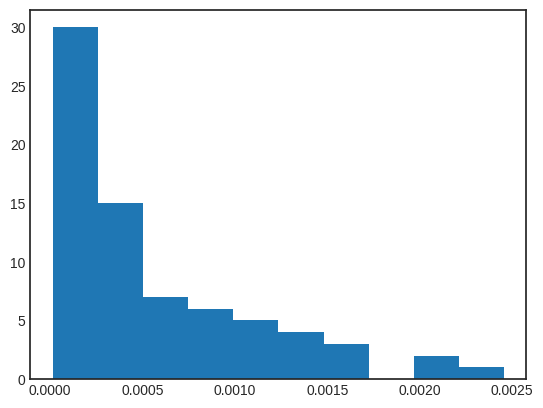

In [7]:
plt.hist(sEMDs)


Text(0, 0.5, 'Observable')

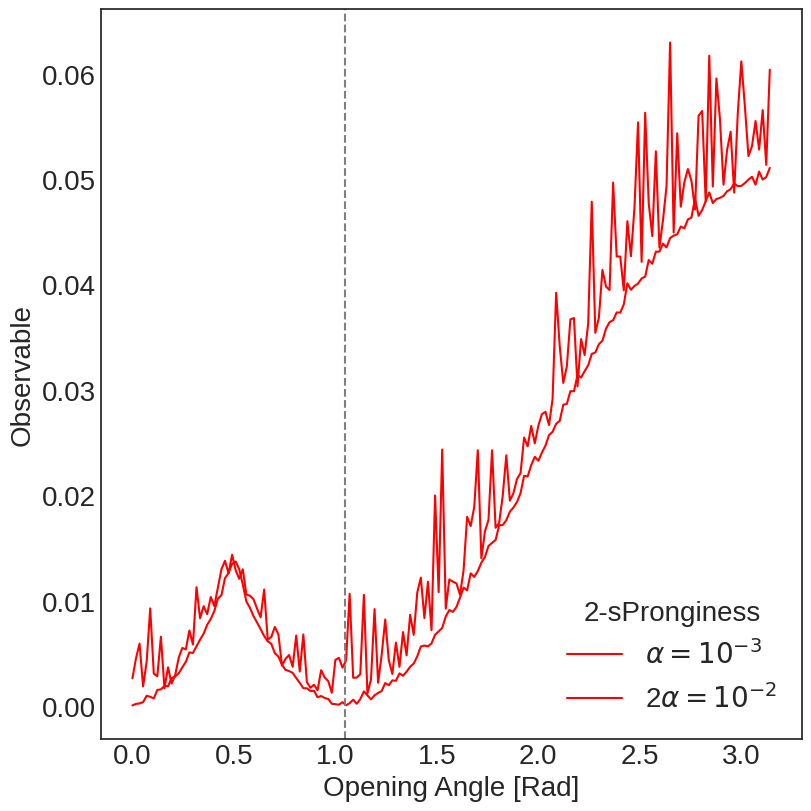

In [18]:
# sEMDs
from tqdm import tqdm

# @jax.jit
def compute_2spronginess(s, alpha = 1e-3):

    batch_size = s.shape[0]
    epochs = 1000



    initial_omega = 0.5
    initial_2ee = 0.2

    # Initialize 2-prong events
    sprongs = np.zeros((batch_size, 2, 2))
    sprongs[:,0,:] = (0, 1-initial_2ee)
    sprongs[:,1,:] = (initial_omega, initial_2ee)

    # Optimizer
    opt_state = None
    opt_init, opt_update, get_params = jax_opt.adam(alpha)
    opt_state = opt_init(sprongs)

    # ts = []
    # ss = []

    for epoch in range(epochs):

        sprongs = get_params(opt_state)
        
        sEMDS = ds2(sprongs, s)
        grads = gradients(sprongs, s)

        opt_state = opt_update(epoch, grads, opt_state)

    #     for i in range(batch_size):
    #         ts.append(epoch)
    #         ss.append(sEMDS[i])

    #     # sprongs = sprongs - 0.01 * grads

    # plt.scatter(ts,ss)
    return sEMDS, sprongs





sEMDs_2, sprongs = compute_2spronginess(s, 1e-2)
sEMDs_3, sprongs = compute_2spronginess(s, 1e-3)

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  

# print(angles.shape, np.array(EMDs).shape)

# plt.plot(angles, 2 * np.square(np.array(EMDs)), color = "black", label = r"$\beta$(2-Pronginess)$^\beta$")
plt.plot(angles, np.array(sEMDs_3), color = "red", label = r"$\alpha = 10^{-3}$")
plt.plot(angles, np.array(sEMDs_2), color = "black", label = r"$\alpha = 10^{-2}$")

plt.axvline(np.pi / 3, color = "grey", ls = "--")
plt.legend(frameon = False, title = "2-sPronginess")

plt.xlabel("Opening Angle [Rad]")
plt.ylabel("Observable")





# def compute_d2prong(angle):

#     sEMDs = []


#     s2prongs = []
#     es = np.linspace(0,0.5, 50)
#     omegas = np.linspace(0,1.5,150)
#     ij = []
#     for (i, e) in enumerate(es):
#         for (j, omega) in enumerate(omegas):
#             s2 = np.array((   (0, 1 - e), (omega, e),     ))
#             s2prongs.append(s2)
#             ij.append((i,j))
#     s2prongs = np.array(s2prongs)
#     ij = np.array(ij)
        


#     indices = [int(angle * 180/np.pi)] * 50*150
#     equilateral_triangles = s[indices]


#     sEMDs = ds2(s2prongs, equilateral_triangles)
#     temp = np.zeros((50,150))
#     temp[ij[:,0], ij[:,1]] = sEMDs

#     argmin = np.unravel_index(np.argmin(temp, axis=None), temp.shape)
#     print(argmin)
#     print(temp[argmin], temp[44,100])
#     plt.imshow(temp)

#     return np.amin(sEMDs)


# compute_d2prong(0)

# # angle_sEMDs = []
# # for angle in tqdm(angles[:-1]):
# #     angle_sEMDs.append(compute_d2prong(angle))








# for angle in tqdm(range(N)):


#     bee = []

#     for energy in range(N):

#         es = np.linspace(0,0.5, 100)
#         omegas = np.array((1,))
#         Es, Omegas = np.meshgrid(es, omegas)
#         temp = np.zeros_like(Es)
    

#         for (i, e) in enumerate(es):
#             for (j, omega) in enumerate(omegas):

#                 s = compute_spectral_representation(events[angle][energy], type = "jet")
#                 s2 = np.array((   (0, 1 - e), (omega, e),     ))
#                 d = ds2(s, s2)
#                 temp[j,i] = d

#         bee.append(np.amin(temp))
#     sEMDs.append(bee)

# sEMDs = np.array(sEMDs)